<a href="https://colab.research.google.com/github/sabeesh90/Multimodal-Architectures-Deep_Learning/blob/main/Thesis_Download_sloan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <p style = "text-align:center"><font color  = 'blue'> Thesis Dissertation - Masters

#### Importing libraries

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#### Reading the tabular data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
%cd drive/MyDrive/Colab Notebooks

In [ ]:
f = open("tabular_data.csv", "r")
# f = open("D:\Data Science\Thesis\1. Datasets\Thesis 1\SLOAN")
a = f.readlines()
f.close()

##### Reading the first record of the csv file

In [ ]:
print(len(a))
a[1001]

1002


'1237648704055214227,217.618134232202,-0.23442684979355,19.51428,18.67359,18.61282,18.63047,18.35689,752,301,3,495,19.00783,4535127118091407360,QSO,2.62735,4028,55621,8\n'

#### Creating a pandas dataframe for analysis

In [ ]:
df = pd.read_csv("tabular_data.csv", skiprows = [0])
df.head(3)

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,fiberMag_g,specobjid,class,redshift,plate,mjd,fiberid
0,1237646587699462283,56.485796,0.843531,17.98595,16.77582,16.22950,16.00589,15.89195,259,301,5,333,17.10288,1837638847656126464,STAR,0.000125,1632,52996,619
1,1237646587699658835,56.901894,0.845330,19.23049,17.21716,16.38172,16.05841,15.88405,259,301,5,336,17.54239,1721609858370791424,STAR,-0.000201,1529,52930,396
2,1237646587709882380,80.224783,0.834251,18.12716,16.95737,16.40913,16.18926,16.05978,259,301,5,492,17.26884,8175272584063242240,STAR,-0.000017,7261,56603,412


In [ ]:
df['class'].value_counts()

STAR      498
GALAXY    440
QSO        62
Name: class, dtype: int64

#### Downloading the image data specific to the corresponding records in the csv file

In [ ]:
# from IPython.display import clear_output
# for i in range(654,len(a)):
#     objid = a[i].split(',')[0]
#     run = a[i].split(',')[8]
#     camcol = a[i].split(',')[10]
#     field = a[i].split(',')[11]
#     ra = a[i].split(',')[1]
#     dec = a[i].split(',')[2]
#     clas = a[i].split(',')[14]
# #     url  = f'http://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/getJpegCodec/?R={run}&C={camcol}&F={field}&Z=0'
#     url = f'http://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/getjpeg?ra={ra}&dec={dec}&scale=0.01&height=2048&width=2048'
#     response = requests.get(url)
#     img = Image.open(BytesIO(response.content))
#     if clas == 'STAR':
#         img.save(f'D:/Data Science/Thesis/1. Datasets/Final/Images/STAR/{objid}.jpg', 'JPEG')
#     elif clas == 'GALAXY':
#         img.save(f'D:/Data Science/Thesis/1. Datasets/Final/Images/GALAXY/{objid}.jpg', 'JPEG')
#     elif clas == 'QSO':
#         img.save(f'D:/Data Science/Thesis/1. Datasets/Final/Images/QSO/{objid}.jpg', 'JPEG')
#     clear_output(wait=True)
#     print(clas, objid, ra, dec,i)

# to download specific image
# http://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/getjpeg?ra=184.9511&dec=-0.8754&scale=0.4&height=512&width=512&opt=GO 

### <font color = "blue"> Custom Deep Learning model

##### **Importing the requisite libraries**

In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 3.4MB/s 


In [ ]:
import os
from skimage import io
import pathlib
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
import kerastuner as kt
%load_ext tensorboard

In [ ]:
classes = ['GALAXY', 'STAR', 'QSO']

#### **Tensorflow conventional loading dataset from directory**

In [ ]:
dataset_path = 'Images'
img_width = 512
img_height = 512
channels = 3
num_classes = 3
batch_size = 32

def generate_data(batch_size = batch_size, img_width = img_width, img_height = img_height):
    channels = 3
    num_classes = 3
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'training',seed = 123, image_size = (img_width, img_height), 
                                                                  batch_size = batch_size, label_mode = 'categorical')
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'validation',seed = 123, image_size = (img_width, img_height),
                                                                batch_size = batch_size, label_mode = 'categorical')
    class_names = train_ds.class_names
    print(class_names)
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    print(f'The number of batches in training data set is {len(train_ds)} and in evaluation set is {len(val_ds)}')

    return (train_ds, val_ds)


In [ ]:
train_ds, val_ds = generate_data()

Found 1000 files belonging to 3 classes.
Using 800 files for training.
Found 1000 files belonging to 3 classes.
Using 200 files for validation.
['GALAXY', 'QSO', 'STAR']
The number of batches in training data set is 25 and in evaluation set is 7


#### **Image augmentation code and testing using conventional tensorflow libraries**


##### Non rigid transformation  - Image augmentation

In [ ]:
data_augmentation  = tf.keras.Sequential(
    [layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), # these are rigid transformation techniques  - flipping, rotation 
     layers.experimental.preprocessing.RandomRotation(0.2)])
# This layer can be added directly to the model bu is done here for testing purposed

In [ ]:
def generate_image(c = 0, n = 0, aug = False):
    dataset_path = 'Images'
    ast_class_path  = os.path.join(dataset_path, classes[c], '*')
    print(ast_class_path)
    # n = np.random.randint(0, len(ast_class_path))
    ast_image_path = glob.glob(ast_class_path)
    # print(ast_image_path[n])
    image = io.imread(ast_image_path[n])
        
    if aug == False:
        print(image.shape)
        plt.imshow(image)
        plt.show()
    else:
        plt.figure(figsize = (15,5))  
        print(image.shape)    
        image_expanded = tf.expand_dims(image,0)
        print(image.shape)  
        augmented_image = data_augmentation(image_expanded)
        plt.figure(figsize = (15,5))
        plt.subplot(1,2,1)
        plt.title('original_image')
        plt.imshow(image)
        plt.subplot(1,2,2)
        plt.title('augmented_image')
        plt.imshow(augmented_image[0])

Images/GALAXY/*


<Figure size 1080x360 with 0 Axes>

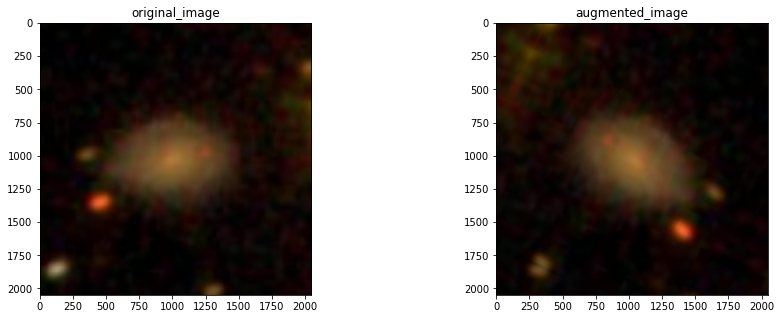

In [ ]:
generate_image(0,4, aug = True)

#### **Defining functions for code shortening**

In [ ]:
def generate_graph(model_training):
    plt.figure(figsize= (15,5))
    plt.subplot(1,2,1)
    plt.plot(model_training.history.history['accuracy'])
    plt.plot(model_training.history.history['val_accuracy'])
    plt.title('Training vs TestAccuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(('Training', 'Validation'), loc = 'best')
    plt.subplot(1,2,2)
    plt.plot(model_training.history.history['loss'])
    plt.plot(model_training.history.history['val_loss'])
    plt.title('Training loss vs Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(('Training', 'Validation'), loc = 'best')
    plt.show()

# Defining callbacks for the models
filepath = './custom_dnn'
reduced_lr = tf.keras.callbacks.ReduceLROnPlateau(factor = 0.2, patience = 5, min_lr = 0.001) # This conssists of the default values
model_checkpoint  = tf.keras.callbacks.ModelCheckpoint(filepath =filepath,save_best_only=True, verbose = 1)
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 10,verbose= 1, monitor = 'val_accuracy')
tensorboard_callback = tf.keras.callbacks.TensorBoard(histogram_freq=1)
callbacks = [reduced_lr, model_checkpoint, early_stopping ,tensorboard_callback]

def run_model(model_training, epochs = 50):
    optimizer = optimizers.Adam(learning_rate = 1e-3)
    model_training.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    print(model_training.summary())
    class_weight = {0:1.13, 1:8.03, 2:1} # this is done by dividing the total number of highest occurence of classes by that particul count of class
    model_training.fit(train_ds,validation_data=val_ds,epochs = epochs, verbose = 1, workers = 3, class_weight  = class_weight)
    generate_graph(model_training)

# optimizer = optimizers.Adam(lr = 1e-3)
# model4.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
# model4.summary()
# model4.fit(train_ds,validation_data=val_ds,epochs = 10, verbose = 1, workers = 3)

#### Baseline model - 128C - 256D - Adam - Accuracy

In [ ]:
def baseline_model(aug=False):
    model = Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
    if aug == True:
        model.add(layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))
        model.add(layers.experimental.preprocessing.RandomRotation(0.2))
    model.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
        
    model.add(Flatten())

    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    # Final layer
    model.add(Dense(num_classes, activation = 'softmax'))
    return model

model1 = baseline_model()
model1_aug = baseline_model(aug  = True)
    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 512, 512, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)     

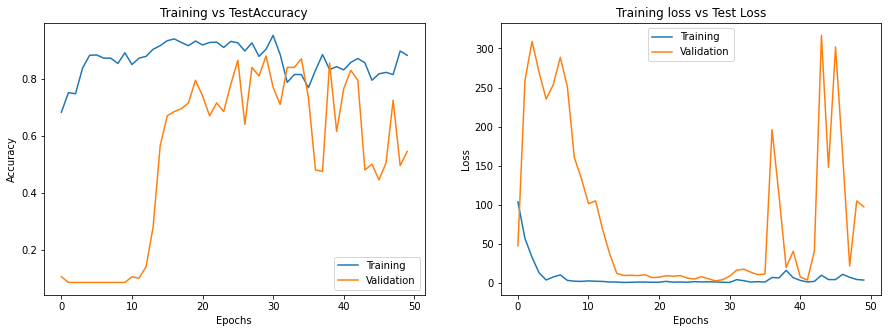

In [ ]:
run_model(model1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 512, 512, 3)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 512, 512, 3)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 512, 512, 32)      896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 512, 512, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 64)     

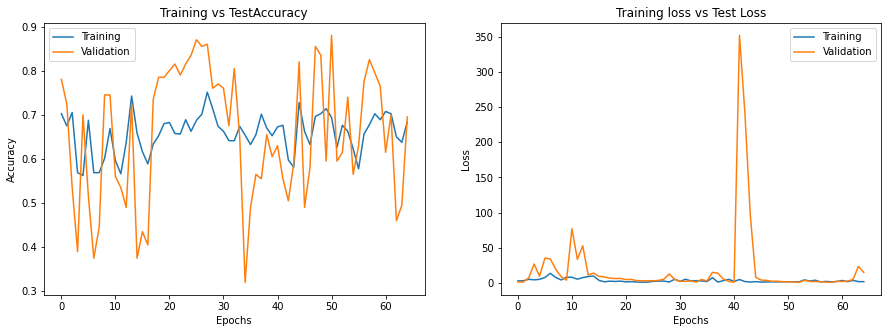

In [ ]:
run_model(model1_aug, epochs = 65)

#### Baseline model - 128C - 256/512D - Adam - Accuracy

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 512, 512, 32)      896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 512, 512, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 128, 128, 64)     

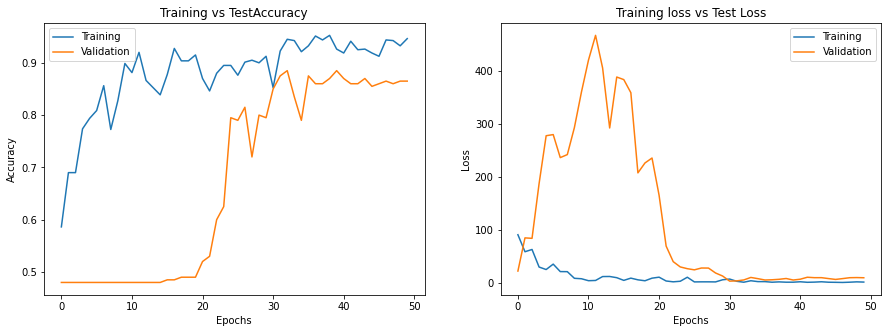

In [ ]:
def baseline_model(aug = False):
    model = Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
    if aug == True:
        model.add(layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))
        model.add(layers.experimental.preprocessing.RandomRotation(0.2))
    model.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
        
    model.add(Flatten())

    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))

    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.5))
    # Final layer
    model.add(Dense(num_classes, activation = 'softmax'))
    return model
    
model2 = baseline_model()
model2_aug = baseline_model(aug = True)
run_model(model2)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 512, 512, 3)       0         
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, 512, 512, 3)       0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 512, 512, 32)      896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 512, 512, 32)      128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 256, 256, 64)     

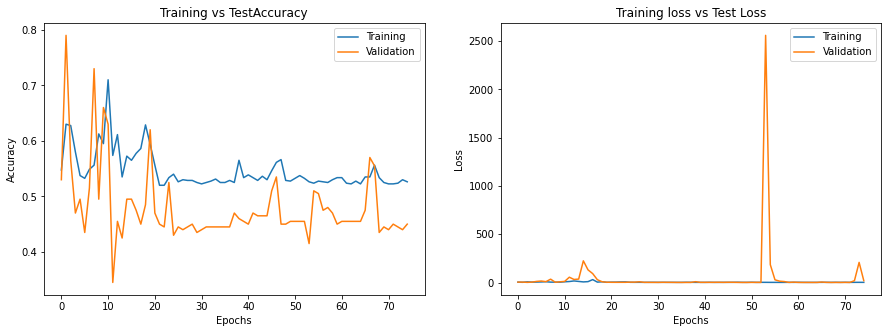

In [ ]:
run_model(model2_aug, epochs = 75)

#### Baseline model - 256C - 512D - Adam - Accuracy

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 512, 512, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 512, 512, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 64)     

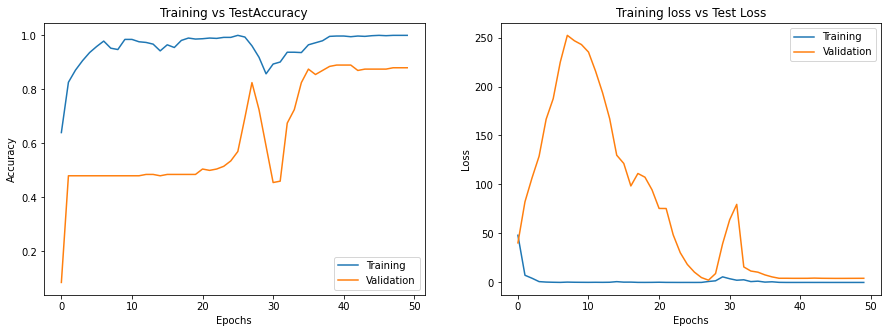

In [ ]:
def baseline_model(aug = False):
    model = Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
    if aug == True:
        model.add(layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))
        # model.add(layers.experimental.preprocessing.RandomRotation(0.2))
    model.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(256, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Flatten())

    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.2))
    # Final layer
    model.add(Dense(num_classes, activation = 'softmax'))
    return model
    
model3 = baseline_model()
run_model(model3)
    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 512, 512, 3)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 512, 512, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 64)     

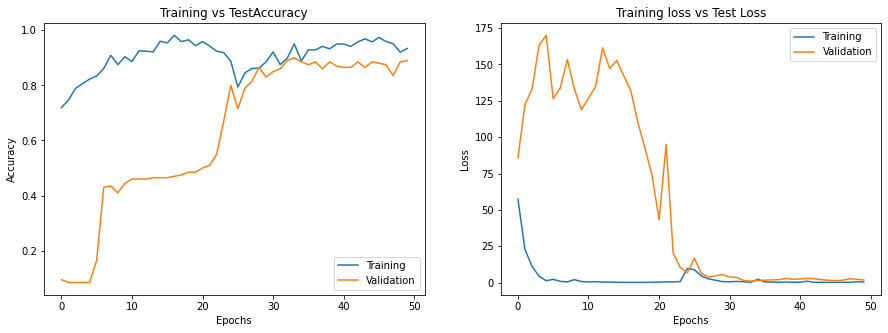

In [ ]:
def baseline_model(aug = False):
    model = Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
    if aug == True:
        model.add(layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))
        # model.add(layers.experimental.preprocessing.RandomRotation(0.2))
    model.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(256, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Flatten())

    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.2))
    # Final layer
    model.add(Dense(num_classes, activation = 'softmax'))
    return model
model3_aug = baseline_model(aug = True)
run_model(model3_aug)

In [ ]:
model3.evaluate(val_ds)

7/7 [==============================] - 0s 58ms/step - loss: 4.2316 - accuracy: 0.8800


[4.231595516204834, 0.8799999952316284]

In [ ]:
model3.predict(val_ds).argmax(axis=1)

array([0, 0, 0, 2, 0, 2, 0, 2, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0,
       0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2,
       2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 0, 0,
       0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 0, 2, 1, 2,
       0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0,
       0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 1,
       2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 1, 0,
       0, 1, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2,
       0, 2])

#### Baseline model - 128C - 256-512D - Adam - Accuracy/0.4D

In [ ]:
def baseline_model(aug = False):
    model = Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
    if aug == True:
        model.add(layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))
    model.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())    
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
      
    model.add(Flatten())

    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.4))

    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.4))

    model.add(Dense(num_classes, activation = 'softmax'))
    return model
    
model4 = baseline_model()
model4_aug = baseline_model(aug = True)

In [ ]:
optimizer = optimizers.Adam(lr = 1e-4)
model4.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
model4_aug.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
model4.summary()
model4.fit(train_ds,validation_data=val_ds,epochs = 50, verbose = 1, workers = 3)
model4_aug.fit(train_ds,validation_data=val_ds,epochs = 50, verbose = 1, workers = 3)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 512, 512, 32)      896       
_________________________________________________________________
batch_normalization_14 (Batc (None, 512, 512, 32)      128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 256, 256, 64)      18496     
_________________________________________________________________
batch_normalization_15 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 128, 128, 64)     

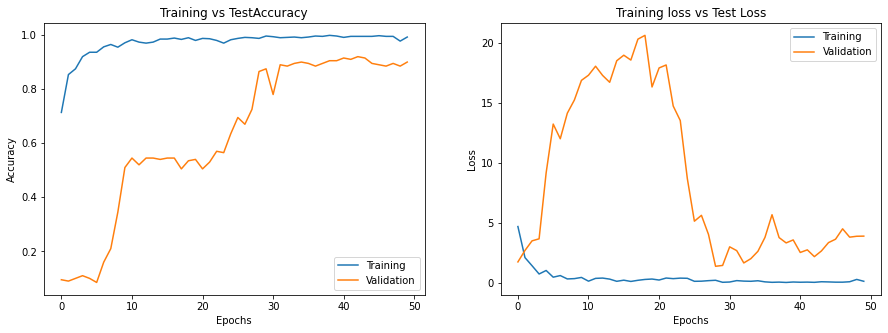

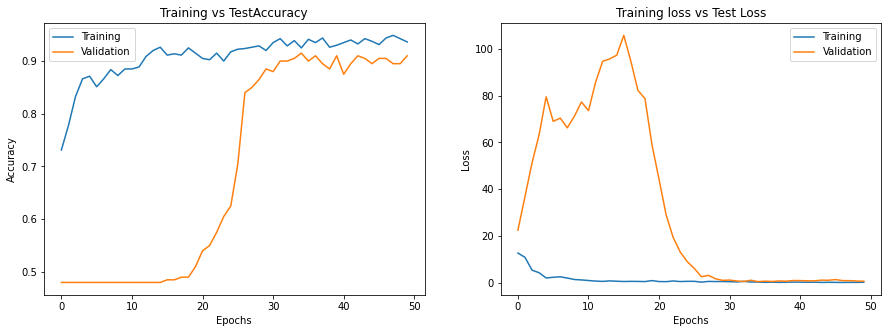

In [ ]:
generate_graph(model4)
generate_graph(model4_aug)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 512, 512, 32)      896       
_________________________________________________________________
batch_normalization_11 (Batc (None, 512, 512, 32)      128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 256, 256, 64)      18496     
_________________________________________________________________
batch_normalization_12 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 128, 128, 64)     

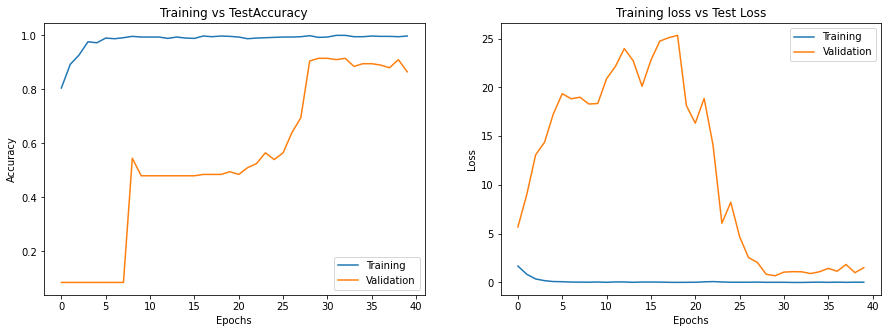

In [ ]:
def baseline_model():
    model = Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))


    model.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())    
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))

    model.add(Conv2D(256, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
      
    model.add(Flatten())

    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.2))

    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.2))

    model.add(Dense(num_classes, activation = 'softmax'))
    return model
    
model5 = baseline_model()
optimizer = optimizers.Adam(lr = 1e-4)
model5.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
model5.summary()
model5.fit(train_ds,validation_data=val_ds,epochs = 40, verbose = 1, workers = 3)
generate_graph(model5)

Plotting the 

#### Baseline model - 256C - 512D - SGD - Accuracy - 0.75 droopout

In [ ]:
def baseline_model(aug = False):
    model = Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
    if aug == True:
        model.add(layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))
    model.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(256, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Flatten())

    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.75))
    # Final layer
    model.add(Dense(num_classes, activation = 'softmax'))
    return model
    
model5 = baseline_model()
model5_aug = baseline_model(aug=True)
optimizer = optimizers.SGD(lr = 1e-4)
model5.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
model5_aug.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
model5.summary()
model5_aug.summary()
    

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 512, 512, 32)      896       
_________________________________________________________________
batch_normalization_20 (Batc (None, 512, 512, 32)      128       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 256, 256, 64)      18496     
_________________________________________________________________
batch_normalization_21 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 128, 128, 64)     

In [ ]:
model5.fit(train_ds,validation_data=val_ds,epochs = 45, verbose = 1, workers = 3)
model5_aug.fit(train_ds,validation_data=val_ds,epochs = 45, verbose = 1, workers = 3)

Epoch 1/45
25/25 [==============================] - 6s 212ms/step - loss: 1.3917 - accuracy: 0.6026 - val_loss: 1.1635 - val_accuracy: 0.0850
Epoch 2/45
25/25 [==============================] - 5s 206ms/step - loss: 0.6920 - accuracy: 0.8194 - val_loss: 1.1739 - val_accuracy: 0.5050
Epoch 3/45
25/25 [==============================] - 5s 205ms/step - loss: 0.3878 - accuracy: 0.8722 - val_loss: 1.2735 - val_accuracy: 0.2750
Epoch 4/45
25/25 [==============================] - 5s 206ms/step - loss: 0.3387 - accuracy: 0.8888 - val_loss: 1.2342 - val_accuracy: 0.4800
Epoch 5/45
25/25 [==============================] - 5s 206ms/step - loss: 0.2726 - accuracy: 0.8970 - val_loss: 1.3493 - val_accuracy: 0.4800
Epoch 6/45
25/25 [==============================] - 5s 206ms/step - loss: 0.2771 - accuracy: 0.9046 - val_loss: 1.3836 - val_accuracy: 0.4800
Epoch 7/45
25/25 [==============================] - 5s 206ms/step - loss: 0.1752 - accuracy: 0.9437 - val_loss: 1.5252 - val_accuracy: 0.4800
Epoch 

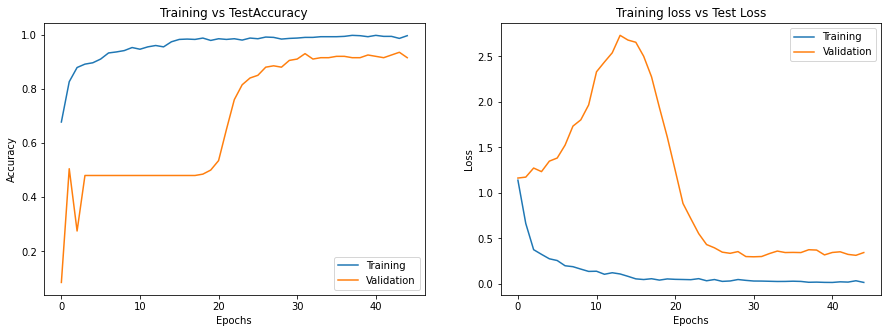

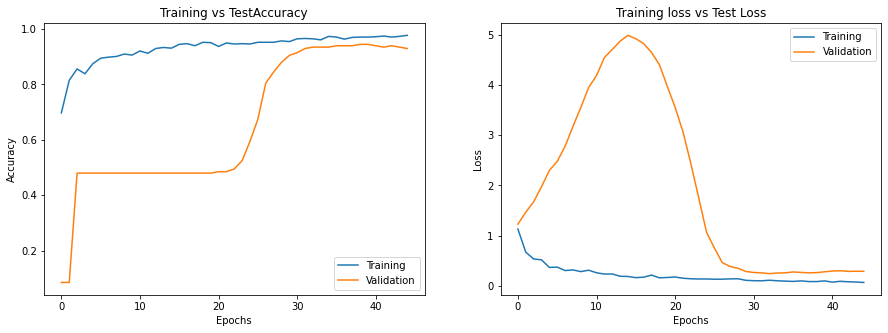

In [ ]:
generate_graph(model5)
generate_graph(model5_aug)

#### Keras tuner - 256C - 512D - Adam - Accuracy without augmentation

In [ ]:
def model_builder_new1(hp):
    model = Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
    model.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())    
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
      
    model.add(Flatten())

    dense_units1 = hp.Int('dense_ratio1', min_value=256, max_value=384, step=128)
    model.add(Dense(dense_units1))
    dropout1_units = hp.Float('dropout_ratio1', min_value=0.25, max_value=0.75, step=0.25)
    model.add(Dropout(dropout1_units))

    dense_units2 = hp.Int('dense_ratio2', min_value=384, max_value=512, step=128)
    model.add(Dense(dense_units2))
    dropout2_units = hp.Float('dropout_ratio2', min_value=0.25, max_value=0.75, step=0.25)
    model.add(Dropout(dropout2_units))

    model.add(Dense(num_classes, activation = 'softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(learning_rate = 1e-4), metrics = ['accuracy'])
    return model

In [ ]:
tuner = kt.Hyperband(hypermodel=model_builder_new1, objective='val_accuracy', max_epochs = 40, directory='./test' , project_name = 'custom_tuner')
early_stopback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(train_ds,validation_data=val_ds, epochs = 40, verbose = 1, workers = 3, callbacks = [early_stopback])

Trial 32 Complete [00h 00m 17s]
val_accuracy: 0.47999998927116394

Best val_accuracy So Far: 0.5400000214576721
Total elapsed time: 00h 25m 13s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hyperparamters = tuner.get_best_hyperparameters()[0]
dense_ratio1= best_hyperparamters.get('dense_ratio1')
dropout_ratio1= best_hyperparamters.get('dropout_ratio1')
dense_ratio2= best_hyperparamters.get('dense_ratio2')
dropout_ratio2= best_hyperparamters.get('dropout_ratio2')

print(f'The best hyperparameter for denseunit1 is {dense_ratio1} and dropout first  {dropout_ratio1} and denseunit2 is {dense_ratio2} and dropout second is {dropout_ratio2}' )

The best hyperparameter for denseunit1 is 384 and dropout first  0.75 and denseunit2 is 512 and dropout second is 0.5


In [ ]:
#### GEtting the best model from the  hyperparmaters
tuner_model = tuner.hypermodel.build(best_hyperparamters)
tuner_model_history  = tuner_model.fit(train_ds,validation_data=val_ds, epochs = 40, verbose = 1, workers = 3,)

Epoch 1/40
25/25 [==============================] - 4s 145ms/step - loss: 19.5149 - accuracy: 0.6690 - val_loss: 10.2074 - val_accuracy: 0.4800
Epoch 2/40
25/25 [==============================] - 3s 138ms/step - loss: 15.9308 - accuracy: 0.8499 - val_loss: 30.0946 - val_accuracy: 0.0850
Epoch 3/40
25/25 [==============================] - 3s 138ms/step - loss: 11.8133 - accuracy: 0.9027 - val_loss: 31.3282 - val_accuracy: 0.0850
Epoch 4/40
25/25 [==============================] - 3s 138ms/step - loss: 7.4646 - accuracy: 0.9236 - val_loss: 43.5072 - val_accuracy: 0.5550
Epoch 5/40
25/25 [==============================] - 3s 138ms/step - loss: 10.3309 - accuracy: 0.9453 - val_loss: 93.1561 - val_accuracy: 0.0850
Epoch 6/40
25/25 [==============================] - 3s 138ms/step - loss: 8.9433 - accuracy: 0.9349 - val_loss: 87.4288 - val_accuracy: 0.5400
Epoch 7/40
25/25 [==============================] - 3s 138ms/step - loss: 4.7234 - accuracy: 0.9393 - val_loss: 127.0124 - val_accuracy: 0

Text(0.5, 1.0, 'Epochs Vvs validation accuracy')

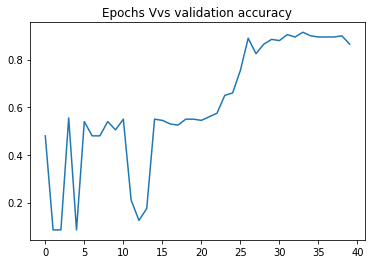

In [ ]:
plt.plot(tuner_model.history.history['val_accuracy'])
plt.title('Epochs vs validation accuracy')

In [ ]:
accuracy_list = tuner_model.history.history['val_accuracy']
best_epoch  = accuracy_list.index(max(accuracy_list))+1
print(f'The best epoch is epoch number {best_epoch}')

The best epoch is epoch number 34


In [ ]:
#### Re training the model
tuner_model = tuner.hypermodel.build(best_hyperparamters)
tuner_model_final  = tuner_model.fit(train_ds,validation_data=val_ds, epochs = best_epoch, verbose = 1, workers = 3)

Epoch 1/34
25/25 [==============================] - 4s 144ms/step - loss: 24.2500 - accuracy: 0.6343 - val_loss: 13.9765 - val_accuracy: 0.4800
Epoch 2/34
25/25 [==============================] - 3s 138ms/step - loss: 21.1321 - accuracy: 0.8419 - val_loss: 22.9163 - val_accuracy: 0.4800
Epoch 3/34
25/25 [==============================] - 3s 137ms/step - loss: 15.7489 - accuracy: 0.8751 - val_loss: 41.8009 - val_accuracy: 0.4800
Epoch 4/34
25/25 [==============================] - 3s 137ms/step - loss: 6.4892 - accuracy: 0.9267 - val_loss: 81.8091 - val_accuracy: 0.4800
Epoch 5/34
25/25 [==============================] - 3s 137ms/step - loss: 13.8412 - accuracy: 0.8956 - val_loss: 113.9456 - val_accuracy: 0.4800
Epoch 6/34
25/25 [==============================] - 3s 137ms/step - loss: 13.8735 - accuracy: 0.9306 - val_loss: 108.5651 - val_accuracy: 0.4800
Epoch 7/34
25/25 [==============================] - 3s 137ms/step - loss: 8.1204 - accuracy: 0.9341 - val_loss: 124.0526 - val_accuracy

Text(0.5, 1.0, 'Tuner modelepochs vs validation accuracy')

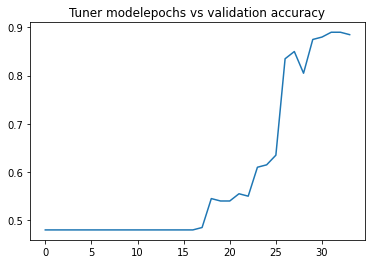

In [ ]:
plt.plot(tuner_model_final.history['val_accuracy'])
plt.title('Tuner modelepochs vs validation accuracy')

#### Resnet -  50 architecture +/- augmentation 

In [ ]:
#### Cusstomized data augmentation of the dataset before feeding into layers unlike previous steps
rescale = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])
data_aug = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")])
batch_size =32 
autotune = tf.data.AUTOTUNE

train_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'training',seed = 123, image_size = (img_width, img_height), 
                                                                  batch_size = batch_size, label_mode = 'categorical')
val_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'validation',seed = 123, image_size = (img_width, img_height),
                                                                batch_size = batch_size, label_mode = 'categorical')

train_ds.map(lambda x,y: (rescale(x), y), num_parallel_calls=autotune)
val_ds.map(lambda x,y: (rescale(x), y), num_parallel_calls=autotune)
val_ds.prefetch(buffer_size=autotune)

def prepare_dataset(ds):
    ds = ds.map(lambda x, y : (data_aug(x, training = True), y), num_parallel_calls = autotune)
    return ds.prefetch(buffer_size =autotune)
    
# 25 batches of 32 each and 7 batches of 32 each

Found 1000 files belonging to 3 classes.
Using 800 files for training.
Found 1000 files belonging to 3 classes.
Using 200 files for validation.


In [ ]:
train_ds_aug = prepare_dataset(train_ds)

In [ ]:
from tensorflow.keras.applications import  ResNet50
# loading the model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape = (img_height, img_width, 3),classes = num_classes, pooling = 'avg',)


94773248/94765736 [==============================] - 3s 0us/step


In [ ]:
layer_count  = len(base_model.layers)
print(f'There are a total of {layer_count} in the resnet layer')
# making the base layers non trainable or freezing
break_point  = 150
for layer in base_model.layers[0:break_point]:
    layer.trainable = False
for layer in base_model.layers[break_point:]:
    layer.trainable = True

# please note higher the break point ; lesser the trainable layers lesser is the over fitting -> high breakpoint -> less over fitting 

There are a total of 176 in the resnet layer


In [ ]:
print(base_model.inputs)
input_layer = base_model.inputs

# Building a functional model
output = base_model.output
x = Dense(512, activation  = 'relu')(output)
x = Dense(num_classes, activation  = 'softmax')(x)
resnet_model = Model(inputs = input_layer, outputs = x)

[<KerasTensor: shape=(None, 512, 512, 3) dtype=float32 (created by layer 'input_5')>]


In [ ]:
resnet_model.summary()
resnet_model.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
resnet_transfer = resnet_model.fit(train_ds,validation_data=val_ds,epochs = 10, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1})

Epoch 1/10
25/25 [==============================] - 27s 814ms/step - loss: 1.0261 - accuracy: 0.7675 - val_loss: 0.5833 - val_accuracy: 0.8150
Epoch 2/10
25/25 [==============================] - 22s 759ms/step - loss: 0.2985 - accuracy: 0.9155 - val_loss: 0.2891 - val_accuracy: 0.8800
Epoch 3/10
25/25 [==============================] - 22s 758ms/step - loss: 0.1883 - accuracy: 0.9479 - val_loss: 0.4802 - val_accuracy: 0.8950
Epoch 4/10
25/25 [==============================] - 22s 758ms/step - loss: 0.1972 - accuracy: 0.9704 - val_loss: 0.3370 - val_accuracy: 0.9250
Epoch 5/10
25/25 [==============================] - 22s 759ms/step - loss: 0.0278 - accuracy: 0.9897 - val_loss: 0.3091 - val_accuracy: 0.9000
Epoch 6/10
25/25 [==============================] - 22s 759ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.3808 - val_accuracy: 0.9200
Epoch 7/10
25/25 [==============================] - 22s 757ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.2928 - val_accuracy: 0.9250

In [ ]:
resnet_transfer_aug = resnet_model.fit(train_ds_aug,validation_data=val_ds,epochs = 10, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1})

Epoch 1/10
25/25 [==============================] - 22s 640ms/step - loss: 1.0408 - accuracy: 0.7127 - val_loss: 0.3790 - val_accuracy: 0.8200
Epoch 2/10
25/25 [==============================] - 19s 618ms/step - loss: 0.7059 - accuracy: 0.8065 - val_loss: 0.3493 - val_accuracy: 0.8750
Epoch 3/10
25/25 [==============================] - 19s 613ms/step - loss: 0.3396 - accuracy: 0.8965 - val_loss: 0.2485 - val_accuracy: 0.9200
Epoch 4/10
25/25 [==============================] - 19s 607ms/step - loss: 0.2488 - accuracy: 0.9309 - val_loss: 0.3686 - val_accuracy: 0.9150
Epoch 5/10
25/25 [==============================] - 19s 610ms/step - loss: 0.1876 - accuracy: 0.9584 - val_loss: 0.2482 - val_accuracy: 0.9300
Epoch 6/10
25/25 [==============================] - 19s 616ms/step - loss: 0.1940 - accuracy: 0.9613 - val_loss: 0.1731 - val_accuracy: 0.9500
Epoch 7/10
25/25 [==============================] - 19s 614ms/step - loss: 0.1159 - accuracy: 0.9736 - val_loss: 0.1947 - val_accuracy: 0.9500

In [ ]:
def generate_graph_transfer(model_training):
    plt.figure(figsize= (15,5))
    plt.subplot(1,2,1)
    plt.plot(model_training.history['accuracy'])
    plt.plot(model_training.history['val_accuracy'])
    plt.title('Training vs TestAccuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(('Training', 'Validation'), loc = 'best')
    plt.subplot(1,2,2)
    plt.plot(model_training.history['loss'])
    plt.plot(model_training.history['val_loss'])
    plt.title('Training loss vs Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(('Training', 'Validation'), loc = 'best')
    plt.show()

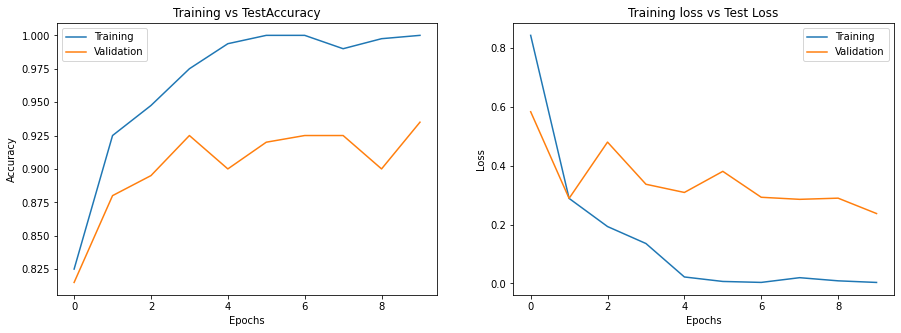

In [ ]:
generate_graph_transfer(resnet_transfer)


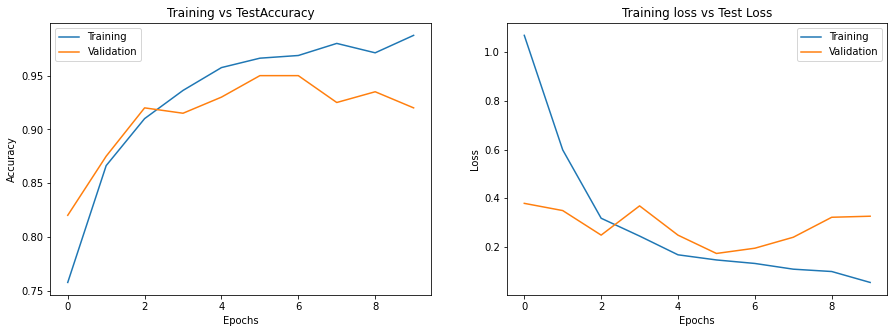

In [ ]:
generate_graph_transfer(resnet_transfer_aug)

#### Densenet 121 +/- augmentation

In [ ]:
base_model_densenet = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",    
    input_shape=(img_height, img_width, channels),
    pooling='max',
    classes=3,
)

In [ ]:
layer_count  = len(base_model_densenet.layers)
print(f'There are a total of {layer_count} layers in the Densenet121 network')

There are a total of 428 layers in the Densenet121 network


In [ ]:
# making the base layers non trainable or freezing
break_point  = 428
for layer in base_model_densenet.layers[0:break_point]:
    layer.trainable = False
for layer in base_model_densenet.layers[break_point:]:
    layer.trainable = True

# please note higher the break point ; lesser the trainable layers lesser is the over fitting -> high breakpoint -> less over fitting 
base_model_densenet.inputs

[<KerasTensor: shape=(None, 512, 512, 3) dtype=float32 (created by layer 'input_9')>]

In [ ]:
input_layer = base_model_densenet.inputs
# Building a functional model

output = base_model_densenet.output
print(output)
# x = Dense(1024,activation  = 'relu')(output)
x = Dense(512, activation  = 'relu')(output)
x = Dense(num_classes, activation  = 'softmax')(x)

densenet_model = Model(inputs = input_layer, outputs = x)
densenet_model.summary()
densenet_model.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), name='max_pool/Max:0', description="created by layer 'max_pool'")
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_8 (ZeroPadding2D (None, 518, 518, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 256, 256, 64) 9408        zero_padding2d_8[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 256

In [ ]:
densenet_model_transfer = densenet_model.fit(train_ds,validation_data=val_ds,epochs = 30, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1})

Epoch 1/30
25/25 [==============================] - 27s 771ms/step - loss: 3.9235 - accuracy: 0.4860 - val_loss: 1.3587 - val_accuracy: 0.6750
Epoch 2/30
25/25 [==============================] - 21s 711ms/step - loss: 1.3546 - accuracy: 0.7352 - val_loss: 1.0049 - val_accuracy: 0.7950
Epoch 3/30
25/25 [==============================] - 21s 711ms/step - loss: 1.1477 - accuracy: 0.8334 - val_loss: 0.8605 - val_accuracy: 0.8150
Epoch 4/30
25/25 [==============================] - 21s 708ms/step - loss: 0.6959 - accuracy: 0.8198 - val_loss: 0.9151 - val_accuracy: 0.7650
Epoch 5/30
25/25 [==============================] - 21s 713ms/step - loss: 0.5673 - accuracy: 0.8445 - val_loss: 0.7356 - val_accuracy: 0.8450
Epoch 6/30
25/25 [==============================] - 21s 713ms/step - loss: 0.4480 - accuracy: 0.8835 - val_loss: 0.7705 - val_accuracy: 0.8150
Epoch 7/30
25/25 [==============================] - 21s 708ms/step - loss: 0.3165 - accuracy: 0.9128 - val_loss: 0.7120 - val_accuracy: 0.8550

In [ ]:
densenet_model_transfer_aug = densenet_model.fit(train_ds_aug,validation_data=val_ds,epochs = 30, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1})

Epoch 1/30
25/25 [==============================] - 25s 661ms/step - loss: 3.9871 - accuracy: 0.5237 - val_loss: 1.3776 - val_accuracy: 0.7500
Epoch 2/30
25/25 [==============================] - 18s 589ms/step - loss: 1.3207 - accuracy: 0.8093 - val_loss: 1.0317 - val_accuracy: 0.7750
Epoch 3/30
25/25 [==============================] - 18s 591ms/step - loss: 1.1660 - accuracy: 0.7985 - val_loss: 1.3222 - val_accuracy: 0.6500
Epoch 4/30
25/25 [==============================] - 18s 592ms/step - loss: 0.9526 - accuracy: 0.7994 - val_loss: 1.0578 - val_accuracy: 0.7450
Epoch 5/30
25/25 [==============================] - 18s 592ms/step - loss: 0.7952 - accuracy: 0.7874 - val_loss: 0.9436 - val_accuracy: 0.7750
Epoch 6/30
25/25 [==============================] - 18s 592ms/step - loss: 0.6104 - accuracy: 0.8490 - val_loss: 1.1715 - val_accuracy: 0.7100
Epoch 7/30
25/25 [==============================] - 18s 598ms/step - loss: 0.7633 - accuracy: 0.8312 - val_loss: 0.8412 - val_accuracy: 0.8300

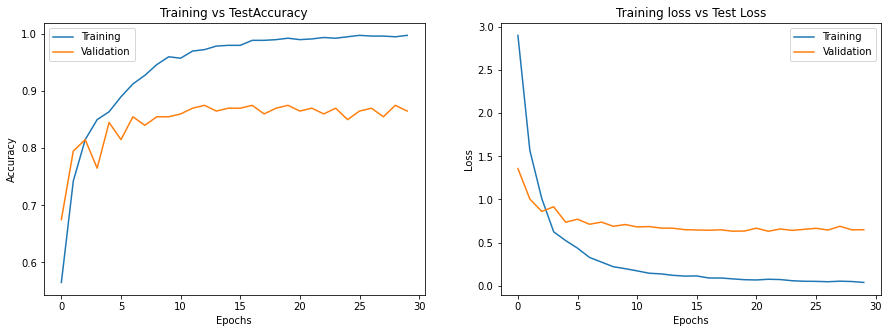

In [ ]:
generate_graph_transfer(densenet_model_transfer)

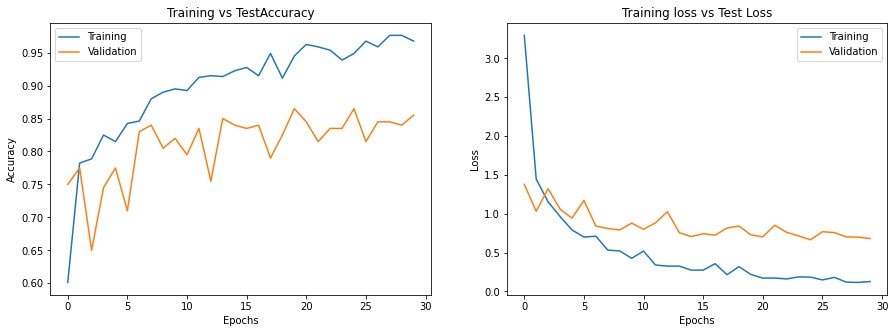

In [ ]:
generate_graph_transfer(densenet_model_transfer_aug)

#### EfficientNet B2 - Google

In [ ]:
base_model_effnet = tf.keras.applications.EfficientNetB2(
    include_top=False,
    weights="imagenet",    
    input_shape=(img_height, img_width, channels),
    pooling='max',
    classes=3,
)

In [ ]:
layer_count  = len(base_model_effnet.layers)
print(f'There are a total of {layer_count} layers in the EfficientNetB2 network')
# making the base layers non trainable or freezing
break_point  = 330
for layer in base_model_effnet.layers[0:break_point]:
    layer.trainable = False
for layer in base_model_effnet.layers[break_point:]:
    layer.trainable = True

# please note higher the break point ; lesser the trainable layers lesser is the over fitting -> high breakpoint -> less over fitting 
base_model_effnet.inputs

There are a total of 340 layers in the EfficientNetB2 network


[<KerasTensor: shape=(None, 512, 512, 3) dtype=float32 (created by layer 'input_3')>]

In [ ]:
input_layer = base_model_effnet.inputs
# Building a functional model

output = base_model_effnet.output
output


<KerasTensor: shape=(None, 1408) dtype=float32 (created by layer 'max_pool')>

In [ ]:
# ['GALAXY', 'QSO', 'STAR']
# 440,62,498
#1.13, 8.03, 1

In [ ]:
#### Cusstomized data augmentation of the dataset before feeding into layers unlike previous steps
rescale = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])
data_aug = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")])
batch_size =8
autotune = tf.data.AUTOTUNE

train_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'training',seed = 123, image_size = (img_width, img_height), 
                                                                  batch_size = batch_size, label_mode = 'categorical')
val_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'validation',seed = 123, image_size = (img_width, img_height),
                                                                batch_size = batch_size, label_mode = 'categorical')

train_ds.map(lambda x,y: (rescale(x), y), num_parallel_calls=autotune)
val_ds.map(lambda x,y: (rescale(x), y), num_parallel_calls=autotune)
val_ds.prefetch(buffer_size=autotune)

def prepare_dataset(ds):
    ds = ds.map(lambda x, y : (data_aug(x, training = True), y), num_parallel_calls = autotune)
    return ds.prefetch(buffer_size =autotune)
    
# 25 batches of 32 each and 7 batches of 32 each
train_ds_aug = prepare_dataset(train_ds)

Found 1000 files belonging to 3 classes.
Using 800 files for training.
Found 1000 files belonging to 3 classes.
Using 200 files for validation.


In [ ]:
x = Dense(256, activation  = 'relu')(output)
x = Dense(num_classes, activation  = 'softmax')(x)

effnet_model = Model(inputs = input_layer, outputs = x)
effnet_model.summary()
effnet_model.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'],)
1.13, 8.03, 1
class_weight = {0:1.13, 1:8.03, 2:1}


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 512, 512, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 512, 512, 3)  7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

In [ ]:
effnet_model_transfer = effnet_model.fit(train_ds,validation_data=val_ds,epochs = 20, verbose = 1, workers = 3, class_weight=class_weight)

Epoch 1/20
100/100 [==============================] - 563s 5s/step - loss: 9.9429 - accuracy: 0.4710 - val_loss: 1.1367 - val_accuracy: 0.7050
Epoch 2/20
100/100 [==============================] - 26s 254ms/step - loss: 5.9107 - accuracy: 0.5861 - val_loss: 2.6035 - val_accuracy: 0.5300
Epoch 3/20
100/100 [==============================] - 26s 255ms/step - loss: 6.1369 - accuracy: 0.5492 - val_loss: 1.3475 - val_accuracy: 0.7250
Epoch 4/20
100/100 [==============================] - 26s 254ms/step - loss: 2.1847 - accuracy: 0.7287 - val_loss: 1.8588 - val_accuracy: 0.6400
Epoch 5/20
100/100 [==============================] - 26s 255ms/step - loss: 2.9704 - accuracy: 0.6948 - val_loss: 4.2133 - val_accuracy: 0.4700
Epoch 6/20
100/100 [==============================] - 26s 254ms/step - loss: 4.6253 - accuracy: 0.6195 - val_loss: 2.0208 - val_accuracy: 0.7100
Epoch 7/20
100/100 [==============================] - 26s 254ms/step - loss: 2.1899 - accuracy: 0.7748 - val_loss: 0.6844 - val_accu

In [ ]:
effnet_model_transfer_aug = effnet_model.fit(train_ds_aug,validation_data=val_ds,epochs = 20, verbose = 1, workers = 3, class_weight=class_weight)

Epoch 1/20
100/100 [==============================] - 33s 228ms/step - loss: 15.3870 - accuracy: 0.3954 - val_loss: 0.6667 - val_accuracy: 0.7700
Epoch 2/20
100/100 [==============================] - 22s 208ms/step - loss: 3.7061 - accuracy: 0.5847 - val_loss: 0.9034 - val_accuracy: 0.7550
Epoch 3/20
100/100 [==============================] - 22s 209ms/step - loss: 3.5095 - accuracy: 0.6369 - val_loss: 2.3405 - val_accuracy: 0.6300
Epoch 4/20
100/100 [==============================] - 22s 208ms/step - loss: 4.3436 - accuracy: 0.5974 - val_loss: 0.9232 - val_accuracy: 0.8100
Epoch 5/20
100/100 [==============================] - 22s 208ms/step - loss: 2.5319 - accuracy: 0.6981 - val_loss: 0.8939 - val_accuracy: 0.8300
Epoch 6/20
100/100 [==============================] - 22s 208ms/step - loss: 1.5334 - accuracy: 0.7798 - val_loss: 1.4827 - val_accuracy: 0.7400
Epoch 7/20
100/100 [==============================] - 22s 205ms/step - loss: 3.2210 - accuracy: 0.6711 - val_loss: 0.9228 - val_a

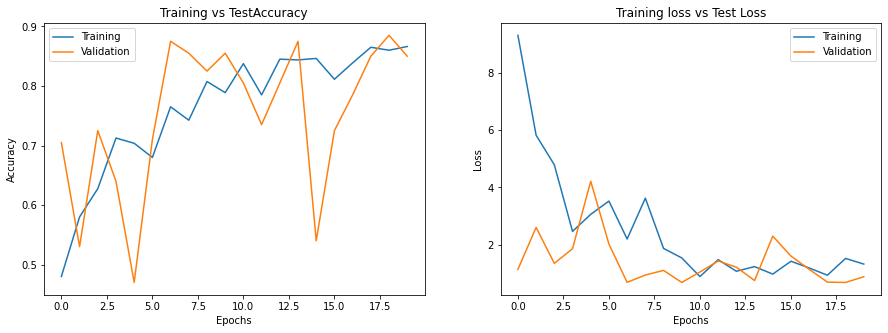

In [ ]:
generate_graph_transfer(effnet_model_transfer)

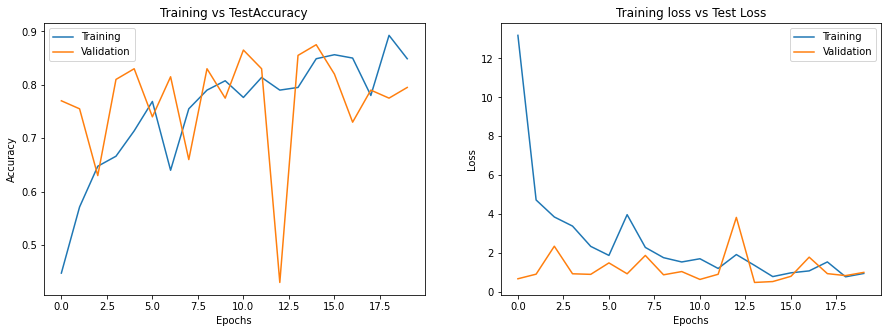

In [ ]:
generate_graph_transfer(effnet_model_transfer_aug)

In [ ]:
#### EfficientNet B2 - Google

#### VGG 16

In [ ]:
base_model_vgg = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",    
    input_shape=(img_height, img_width, channels),
    pooling='max',
    classes=3,
)
layer_count  = len(base_model_vgg.layers)
print(f'There are a total of {layer_count} layers in the VGG 16 network')
# making the base layers non trainable or freezing

There are a total of 20 layers in the VGG 16 network


In [ ]:
break_point  = 16
for layer in base_model_vgg.layers[0:break_point]:
    layer.trainable = False
for layer in base_model_vgg.layers[break_point:]:
    layer.trainable = True

# please note higher the break point ; lesser the trainable layers lesser is the over fitting -> high breakpoint -> less over fitting 
base_model_vgg.inputs
input_layer = base_model_vgg.inputs
# Building a functional model

output = base_model_vgg.output
output

<KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'global_max_pooling2d_4')>

In [ ]:
x = Dense(256, activation  = 'relu')(output)
x = Dense(num_classes, activation  = 'softmax')(x)

vgg_model = Model(inputs = input_layer, outputs = x)
vgg_model.summary()
vgg_model.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0   

In [ ]:
vgg_model.fit(train_ds,validation_data=val_ds,epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1})

Epoch 1/40
25/25 [==============================] - 28s 923ms/step - loss: 5.0121 - accuracy: 0.5930 - val_loss: 1.1402 - val_accuracy: 0.6450
Epoch 2/40
25/25 [==============================] - 27s 911ms/step - loss: 0.7990 - accuracy: 0.8042 - val_loss: 0.6046 - val_accuracy: 0.7850
Epoch 3/40
25/25 [==============================] - 27s 903ms/step - loss: 0.3360 - accuracy: 0.9123 - val_loss: 0.4097 - val_accuracy: 0.8650
Epoch 4/40
25/25 [==============================] - 27s 910ms/step - loss: 0.1112 - accuracy: 0.9606 - val_loss: 0.3591 - val_accuracy: 0.8750
Epoch 5/40
25/25 [==============================] - 27s 905ms/step - loss: 0.0371 - accuracy: 0.9922 - val_loss: 0.3503 - val_accuracy: 0.8950
Epoch 6/40
25/25 [==============================] - 27s 912ms/step - loss: 0.0156 - accuracy: 1.0000 - val_loss: 0.3574 - val_accuracy: 0.8900
Epoch 7/40
25/25 [==============================] - 27s 910ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.3943 - val_accuracy: 0.8950

In [ ]:
vgg_model = vgg_model.fit(train_ds_aug,validation_data=val_ds,epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1})

Epoch 1/40
100/100 [==============================] - 23s 213ms/step - loss: 5.1368 - accuracy: 0.6399 - val_loss: 0.8082 - val_accuracy: 0.6950
Epoch 2/40
100/100 [==============================] - 22s 213ms/step - loss: 0.8319 - accuracy: 0.8185 - val_loss: 1.2303 - val_accuracy: 0.6850
Epoch 3/40
100/100 [==============================] - 22s 212ms/step - loss: 0.6557 - accuracy: 0.8367 - val_loss: 0.8125 - val_accuracy: 0.7400
Epoch 4/40
100/100 [==============================] - 22s 212ms/step - loss: 0.6348 - accuracy: 0.8659 - val_loss: 0.6840 - val_accuracy: 0.7850
Epoch 5/40
100/100 [==============================] - 22s 213ms/step - loss: 0.4505 - accuracy: 0.9167 - val_loss: 1.2958 - val_accuracy: 0.6300
Epoch 6/40
100/100 [==============================] - 22s 212ms/step - loss: 0.7322 - accuracy: 0.8589 - val_loss: 0.5587 - val_accuracy: 0.8450
Epoch 7/40
100/100 [==============================] - 22s 213ms/step - loss: 0.3407 - accuracy: 0.9019 - val_loss: 0.5329 - val_ac

#### Xception

In [ ]:
base_model_xception = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",    
    input_shape=(img_height, img_width, channels),
    pooling='max',
    classes=3,
)
layer_count  = len(base_model_xception.layers)
print(f'There are a total of {layer_count} layers in the Xception network')
# making the base layers non trainable or freezing



There are a total of 133 layers in the Xception network


In [ ]:
break_point  = 123
for layer in base_model_xception.layers[0:break_point]:
    layer.trainable = False
for layer in base_model_xception.layers[break_point:]:
    layer.trainable = True

In [ ]:
print(base_model_xception.input) 
input = base_model_xception.input
output = base_model_xception.output
x = Dense(256, activation  = 'relu')(output)
x = Dense(num_classes, activation  = 'softmax')(x)

xception_model = Model(inputs = input, outputs = x)
xception_model.summary()
xception_model.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])


KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='input_10'), name='input_10', description="created by layer 'input_10'")
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 255, 255, 32) 864         input_10[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 255, 255, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (No

In [ ]:
xception_model_his = xception_model.fit(train_ds,validation_data=val_ds,epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1})

Epoch 1/40
25/25 [==============================] - 34s 1s/step - loss: 1.5224 - accuracy: 0.6039 - val_loss: 1.0939 - val_accuracy: 0.6350
Epoch 2/40
25/25 [==============================] - 29s 998ms/step - loss: 1.0470 - accuracy: 0.7478 - val_loss: 0.7214 - val_accuracy: 0.7450
Epoch 3/40
25/25 [==============================] - 29s 1s/step - loss: 0.8305 - accuracy: 0.7563 - val_loss: 0.5295 - val_accuracy: 0.7800
Epoch 4/40
25/25 [==============================] - 29s 999ms/step - loss: 0.6625 - accuracy: 0.8055 - val_loss: 0.6549 - val_accuracy: 0.6950
Epoch 5/40
25/25 [==============================] - 29s 998ms/step - loss: 0.5598 - accuracy: 0.8369 - val_loss: 0.3879 - val_accuracy: 0.8450
Epoch 6/40
25/25 [==============================] - 28s 978ms/step - loss: 0.5069 - accuracy: 0.8756 - val_loss: 0.4106 - val_accuracy: 0.8650
Epoch 7/40
25/25 [==============================] - 28s 972ms/step - loss: 0.4680 - accuracy: 0.8759 - val_loss: 0.3853 - val_accuracy: 0.8600
Epoch

In [ ]:
xception_model_his_aug = xception_model.fit(train_ds_aug,validation_data=val_ds,epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1})

Epoch 1/40
100/100 [==============================] - 22s 211ms/step - loss: 1.0099 - accuracy: 0.7750 - val_loss: 0.4338 - val_accuracy: 0.8000
Epoch 2/40
100/100 [==============================] - 22s 207ms/step - loss: 0.7891 - accuracy: 0.8288 - val_loss: 0.4651 - val_accuracy: 0.7900
Epoch 3/40
100/100 [==============================] - 22s 207ms/step - loss: 0.7381 - accuracy: 0.8225 - val_loss: 0.6216 - val_accuracy: 0.7550
Epoch 4/40
100/100 [==============================] - 22s 208ms/step - loss: 0.6172 - accuracy: 0.8462 - val_loss: 0.8107 - val_accuracy: 0.6250
Epoch 5/40
100/100 [==============================] - 22s 210ms/step - loss: 0.5545 - accuracy: 0.8650 - val_loss: 0.3346 - val_accuracy: 0.8500
Epoch 6/40
100/100 [==============================] - 22s 208ms/step - loss: 0.5502 - accuracy: 0.8625 - val_loss: 0.4127 - val_accuracy: 0.8250
Epoch 7/40
100/100 [==============================] - 22s 207ms/step - loss: 0.5412 - accuracy: 0.8537 - val_loss: 0.3730 - val_ac

#### Loading images and labels here

In [ ]:
def load_image_labels(image_path, target_size = (256,256)):
    image = tf.io.read_file(image_path)
    image = tf.decode_jpeg(image)

### <font color = "blue"> Univariate analysis

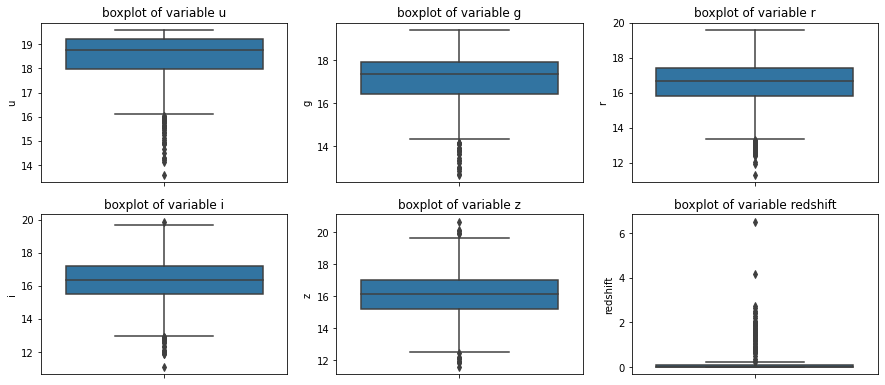

In [ ]:
plt.figure(figsize = (15,10))
for i in range(1, len (df1.columns)):
    plt.subplot(3,3,i)
    sns.boxplot(y = df1[df1.columns[i-1]])
    plt.title('boxplot of variable ' + df1.columns[i-1])
plt.show()

   <font color = 'blue'>
    1.Outliers are present in all the variables present here <br>
    2. Elimination of outliers needs to be done during data preparation stage

 

##### Dsitribution of target variable

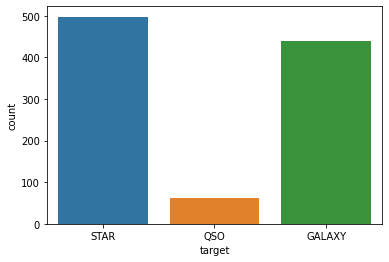

In [ ]:
sns.countplot(x = df1['target'])

### <font color = "blue"> Bivariate analysis

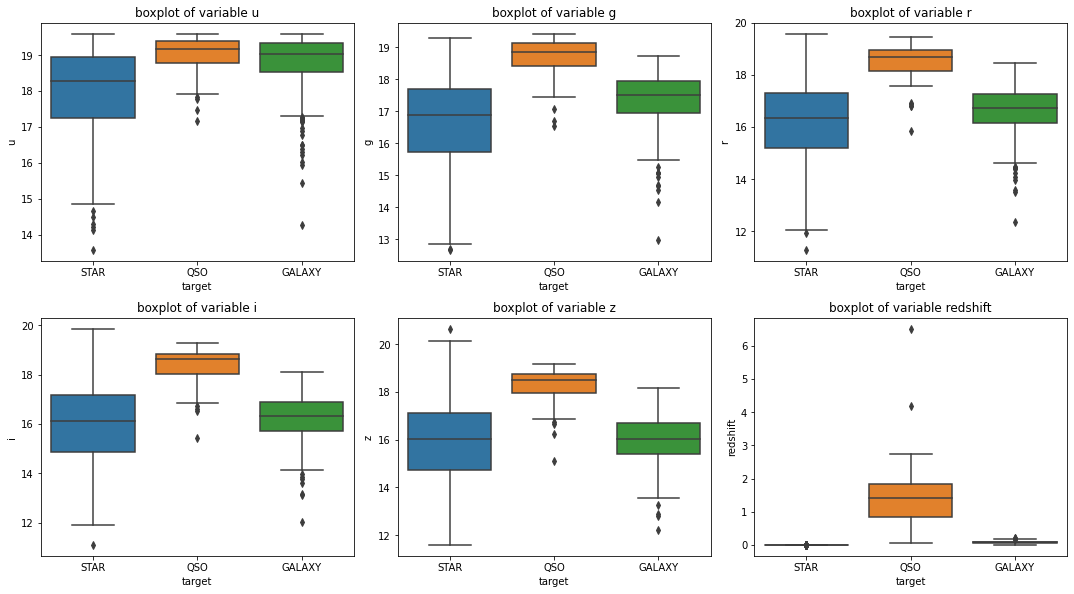

In [ ]:
plt.figure(figsize = (15,12))
for i in range(1, len (df1.columns)):
    plt.subplot(3,3,i)
    sns.boxplot(y = df1[df1.columns[i-1]], x = df1['target'])
    plt.title('boxplot of variable ' + df1.columns[i-1])
    plt.tight_layout(pad=1)
plt.show()

##### Correlation matrix

In [ ]:
df1.corr()

,u,g,r,i,z,redshift
u,1.000000,0.882630,0.761892,0.698621,0.646904,0.180389
g,0.882630,1.000000,0.953533,0.921637,0.899306,0.313528
r,0.761892,0.953533,1.000000,0.982368,0.964247,0.328689
i,0.698621,0.921637,0.982368,1.000000,0.986483,0.330984
z,0.646904,0.899306,0.964247,0.986483,1.000000,0.327181
redshift,0.180389,0.313528,0.328689,0.330984,0.327181,1.000000


##### Visualizing the heat map

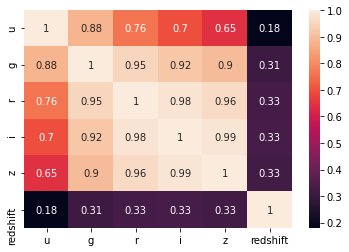

In [ ]:
sns.heatmap(df1.corr(), annot = True)
plt.show()